In [1]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [4]:
import torch
from vector_quantize_pytorch import VectorQuantize
import os
from data.neural_field_datasets import MnistNeFDataset, TokenTransform
from training import training_nano_gpt

from networks.nano_gpt import GPTConfig

torch.cuda.is_available()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: luca-fanselau (adl-for-cv). Use `wandb login --relogin` to force relogin


False

In [5]:
kwargs = {
"type": "pretrained",
"fixed_label": None,
}

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv")

# load used vector quantizer
vq_dicts = torch.load(os.path.join(data_root, "models", "vqs", "vq_mnist_with_all_5_conditioned_n_501.pt"))
vq = VectorQuantize(**vq_dicts["vq_config"])
vq.load_state_dict(vq_dicts["state_dict"])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/luca/uni/master/second-semester/adl4cv/models/vqs/vq_mnist_with_all_5_conditioned_n_501.pt'

In [4]:
dataset = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), transform=TokenTransform(vq), **kwargs)
len(dataset)

60000

In [5]:
# Config Training
config = training_nano_gpt.Config()
config.learning_rate=2e-3
config.max_iters = 25000
config.weight_decay=0.0
config.decay_lr=True
config.lr_decay_iters=config.max_iters
config.warmup_iters=0.05*config.max_iters
config.batch_size = 32
config.gradient_accumulation_steps = 1
config.init_from = "scratch"
config.out_dir ="models/token_transformer"
config.detailed_folder = "training_sample_5"
config.eval_interval = 250
config.metric_interval = 250

model_config = GPTConfig(n_embd=108, block_size=len(dataset[0][0]), n_head=12, n_layer=6, vocab_size=vq_dicts["vq_config"]["codebook_size"] + 11, dropout=0.0)


In [6]:
#early_stopping = training_nano_gpt.EarlyStopper(20)

In [7]:
"""model_config = GPTConfig(
    n_embd=120, 
    block_size=len(dataset[0][0]), 
    n_head=12, n_layer=6, 
    vocab_size=vq_dicts["vq_config"]["codebook_size"] + 1,
    dropout=0.0
    )"""

'model_config = GPTConfig(\n    n_embd=120, \n    block_size=len(dataset[0][0]), \n    n_head=12, n_layer=6, \n    vocab_size=vq_dicts["vq_config"]["codebook_size"] + 1,\n    dropout=0.0\n    )'

In [8]:
cb_size = vq_dicts["vq_config"]["codebook_size"]
token_dict = {
    "SOS": cb_size - 11,
    "0": cb_size - 10,
    "1": cb_size - 9,
    "2": cb_size - 8,
    "3": cb_size - 7,
    "4": cb_size - 6,
    "5": cb_size - 5,
    "6": cb_size - 4,
    "7": cb_size - 3,
    "8": cb_size - 2,
    "9": cb_size - 1
}


In [9]:
# Where to put?
# Maybe adjust dataset to be able to work with splitting data and then rewrite TokenTransform 
# to do the job combined with pytorch dataloader (get_batch == __call__ of Dataloader)

def create_split_indices(n, train_ratio=0.9):
    # Generate a random permutation of indices from 0 to n-1
    shuffled_indices = torch.randperm(n)
    # Determine the cut-off for training data
    train_size = int(train_ratio * n)
    # Split indices into training and validation sets
    train_indices = shuffled_indices[:train_size]
    val_indices = shuffled_indices[train_size:]
    return train_indices, val_indices

train_indices, val_indices = create_split_indices(len(dataset))

def get_batch_lambda(config, dataset, model_config, split):
    batch_size = config.batch_size
    

    # Select indices based on the split
    if split == 'train':
        # Randomly select batch_size indices from the train_indices
        indices = train_indices[torch.randint(0, len(train_indices), (batch_size,))]
    elif split == 'val':
        # Randomly select batch_size indices from the val_indices
        indices = val_indices[torch.randint(0, len(val_indices), (batch_size,))]
    
    
    # Initialize lists to hold the sequences and labels
    samples = []
    labels = []

    # Collect samples and labels
    for idx in indices:
        sample, label = dataset[idx]
        start_tokens = torch.Tensor([token_dict["SOS"], token_dict[str(label)]]).long()  # Start of sequence token
        sample = torch.cat((start_tokens, sample), dim=0)
        #start_tokens = torch.Tensor([0]).long()  # Start of sequence token
        #sample = torch.cat((start_tokens, sample + 1), dim=0)
        samples.append(sample)
        labels.append(label)

    # Prepare the sequences for model input
    max_len = samples[0].size(0)
    x = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    y = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    
    for i, sample in enumerate(samples):
        end_index = sample.size(0) - 1
        x[i, :end_index] = sample[:-1]  # Exclude the last token for x
        y[i, :end_index] = sample[1:]   # Exclude the first token for y

    # Ensure x and y are the correct shape (batch_size, block_size) if needed:
    # Here, we truncate to `block_size` if samples are longer than `block_size`.
    x = x[:, :model_config.block_size]
    y = y[:, :model_config.block_size]

    # x and y have to be
    x = x.to(config.device)
    y = y.to(config.device)

    return x, y

create_get_batch = lambda config, dataset, model_config: lambda split: get_batch_lambda(config, dataset, model_config, split)
get_batch = create_get_batch(config, dataset, model_config)

In [10]:
len(train_indices)*dataset[0][0].shape[0]

30294000

In [11]:
# Prepeare model parameters and train
import wandb
wandb.login()
trained_model = training_nano_gpt.train(get_batch, config, model_config, vq, vq_dicts["vq_config"], token_dict=token_dict)


Initializing a new model from scratch
number of parameters: 0.88M
num decayed parameter tensors: 26, with 928,044 parameters
num non-decayed parameter tensors: 50, with 8,640 parameters
using fused AdamW: True


step 0: train loss 5.5711, val loss 5.5705
step 250: train loss 3.6609, val loss 3.6622
saving checkpoint to models/token_transformer
step 500: train loss 3.5599, val loss 3.5406
saving checkpoint to models/token_transformer
step 750: train loss 3.4912, val loss 3.4730
saving checkpoint to models/token_transformer
step 1000: train loss 3.3984, val loss 3.3828
saving checkpoint to models/token_transformer
step 1250: train loss 3.2897, val loss 3.2931
saving checkpoint to models/token_transformer
step 1500: train loss 3.1931, val loss 3.1998
saving checkpoint to models/token_transformer
step 1750: train loss 3.1084, val loss 3.0913
saving checkpoint to models/token_transformer
step 2000: train loss 3.0090, val loss 3.0086
saving checkpoint to models/token_transformer
step 2250: train loss 2.9318, val loss 2.9448
saving checkpoint to models/token_transformer
step 2500: train loss 2.8639, val loss 2.8792
saving checkpoint to models/token_transformer
step 2750: train loss 2.8279, val loss 2

In [16]:
import matplotlib.pyplot as plt
import torch
from networks.nano_gpt import GPT
from utils import get_default_device

model_dict = torch.load("./models/token_transformer/ckpt.pt")
# Configuration
idx = 3

device = get_default_device()
model = GPT(model_config)#model_dict["model_args"])
model.to(device=device)
model.load_state_dict(model_dict["model"])
model.eval()

vq = VectorQuantize(**model_dict["vq_config"])
vq.load_state_dict(model_dict["vq_state_dict"])
vq.eval()

dataset = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), transform=TokenTransform(vq), **kwargs)


sample = dataset[0][0]
X, Y = get_batch('val')
X, Y = (X[0].unsqueeze(0), Y[0].unsqueeze(0))
pred, _ = model(X, Y)
# Sanity Check
# Should be all true except first/second element
pred.argmax(dim=-1)==Y


number of parameters: 0.88M


tensor([[False, False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False,  True, False, False, False, False,
          True, False, False, False, False, False,  True,  True, False, False,
         False, False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False,  True,  True, False, False,  True,
         False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True,  True,  True,
         False, False, False,  True, False, False, False, False,  True, False,
         False, False, False, False,  True, False, False, False, False, False,
         False, False, False, False, False,  True, False, False,  True, False,
         False,  True, False,  True,  True, False, False,  True, False, False,
         False, False,  True, False, False, False, False,  True,  True, False,
          True, False, False,  True,  True,  True, F

tensor(6, device='cuda:0')
tensor(6, device='cuda:0')
tensor(2, device='cuda:0')
tensor(5, device='cuda:0')


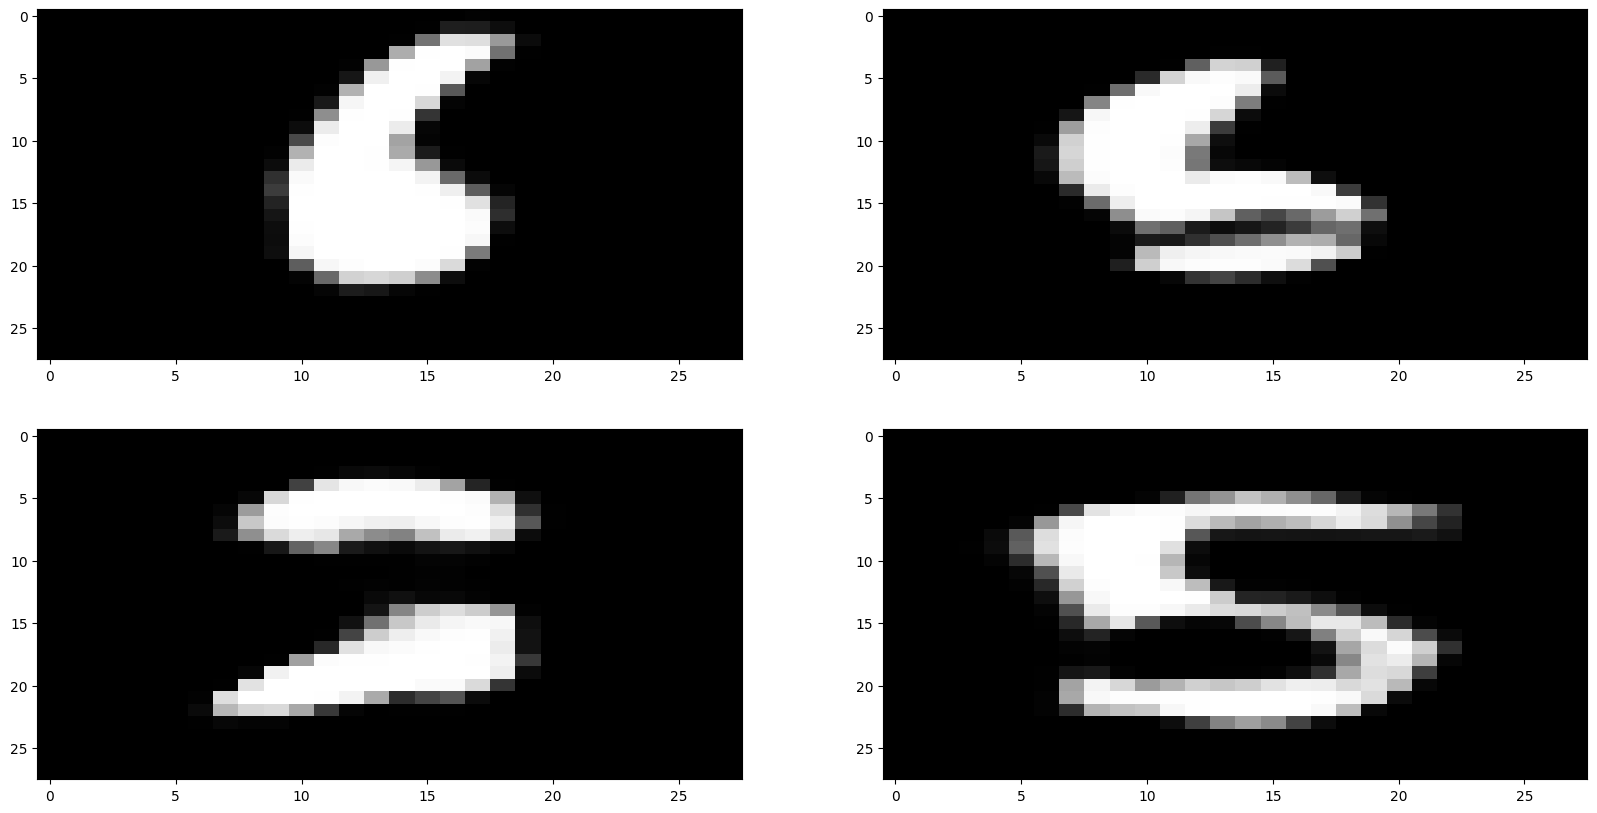

In [19]:
from animation.util import backtransform_weights, reconstruct_image
from networks.mlp_models import MLP3D

ij_len = 2
# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(ij_len, ij_len, figsize=(20, 10))

SOS = torch.Tensor([[0]]).long().to(device)

kwargs = {
"type": "pretrained",
"fixed_label": None,
}

for i in range(ij_len):
    for j in range(ij_len):

        model.eval()
        novel_tokens = model.generate(SOS, dataset[0][0].shape[0] + 1, temperature=1.0, top_k=None)[:, 1:]

        print(novel_tokens[0][0])
        novel_tokens = novel_tokens[:, 1:].unsqueeze(-1).to("cpu")
                                                                                                                         

        max_similarity = 0
        """
        for data in dataset:
            similarity = (data[0].to(device)==novel_tokens.squeeze(-1).squeeze(0).to(device)).int().sum()
            if similarity > max_similarity:
                max_similarity = similarity
        """
        #print(f"Maximum Similarity of picture (i, j) {(i, j)}: {max_similarity}")

        novel_weights= vq.get_codes_from_indices((novel_tokens-11))

        dataset_no_transform = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), **kwargs)
        original_dict = dataset_no_transform[0][0]

        reconstructed_dict = backtransform_weights(novel_weights, original_dict["state_dict"])

        mlp3d = MLP3D(**original_dict["model_config"])
        mlp3d.load_state_dict(reconstructed_dict)
        reconstructed_tensor = reconstruct_image(mlp3d)

        axes[i][j].imshow(reconstructed_tensor, cmap='gray', aspect='auto')

plt.show()